In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import pickle
import tree_parser
import graphviz

from sklearn.tree import DecisionTreeClassifier, export_graphviz, export_text, plot_tree
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report

In [2]:
with open("data/splited_data.pickle", "rb") as file:
    data = pickle.load(file)
    X_train = data["X_train"]
    y_train = data["y_train"]
    X_test = data["X_test"]
    y_test = data["y_test"]

In [3]:
steps = [("imputation", SimpleImputer(missing_values="?", strategy="most_frequent")),
         ("encoder", OneHotEncoder(drop="first")),
         ("classifier", DecisionTreeClassifier())]

In [4]:
param_grid = {"classifier__max_features": range(5, 41, 5),
              "classifier__max_depth": range(5, 31, 5),
              "classifier__min_samples_leaf": [5, 10, 30, 60, 70, 100]}
                                                                     

pipeline = Pipeline(steps)

pipe_cv = GridSearchCV(estimator=pipeline,
                        param_grid=param_grid,
                        scoring="accuracy",
                        n_jobs=-1,
                        cv=10,
                        refit=True)

pipe_cv.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('imputation',
                                        SimpleImputer(missing_values='?',
                                                      strategy='most_frequent')),
                                       ('encoder', OneHotEncoder(drop='first')),
                                       ('classifier',
                                        DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': range(5, 31, 5),
                         'classifier__max_features': range(5, 41, 5),
                         'classifier__min_samples_leaf': [5, 10, 30, 60, 70,
                                                          100]},
             scoring='accuracy')

In [5]:
best_model = pipe_cv.best_estimator_

In [6]:
pipe_cv.best_score_

1.0

In [7]:
pipe_cv.best_params_

{'classifier__max_depth': 10,
 'classifier__max_features': 40,
 'classifier__min_samples_leaf': 5}

In [8]:
y_train_pred = best_model.predict(X_train)
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2622
           1       1.00      1.00      1.00      2821

    accuracy                           1.00      5443
   macro avg       1.00      1.00      1.00      5443
weighted avg       1.00      1.00      1.00      5443



In [9]:
feature_names = best_model[1].get_feature_names_out(X_train.columns).tolist()

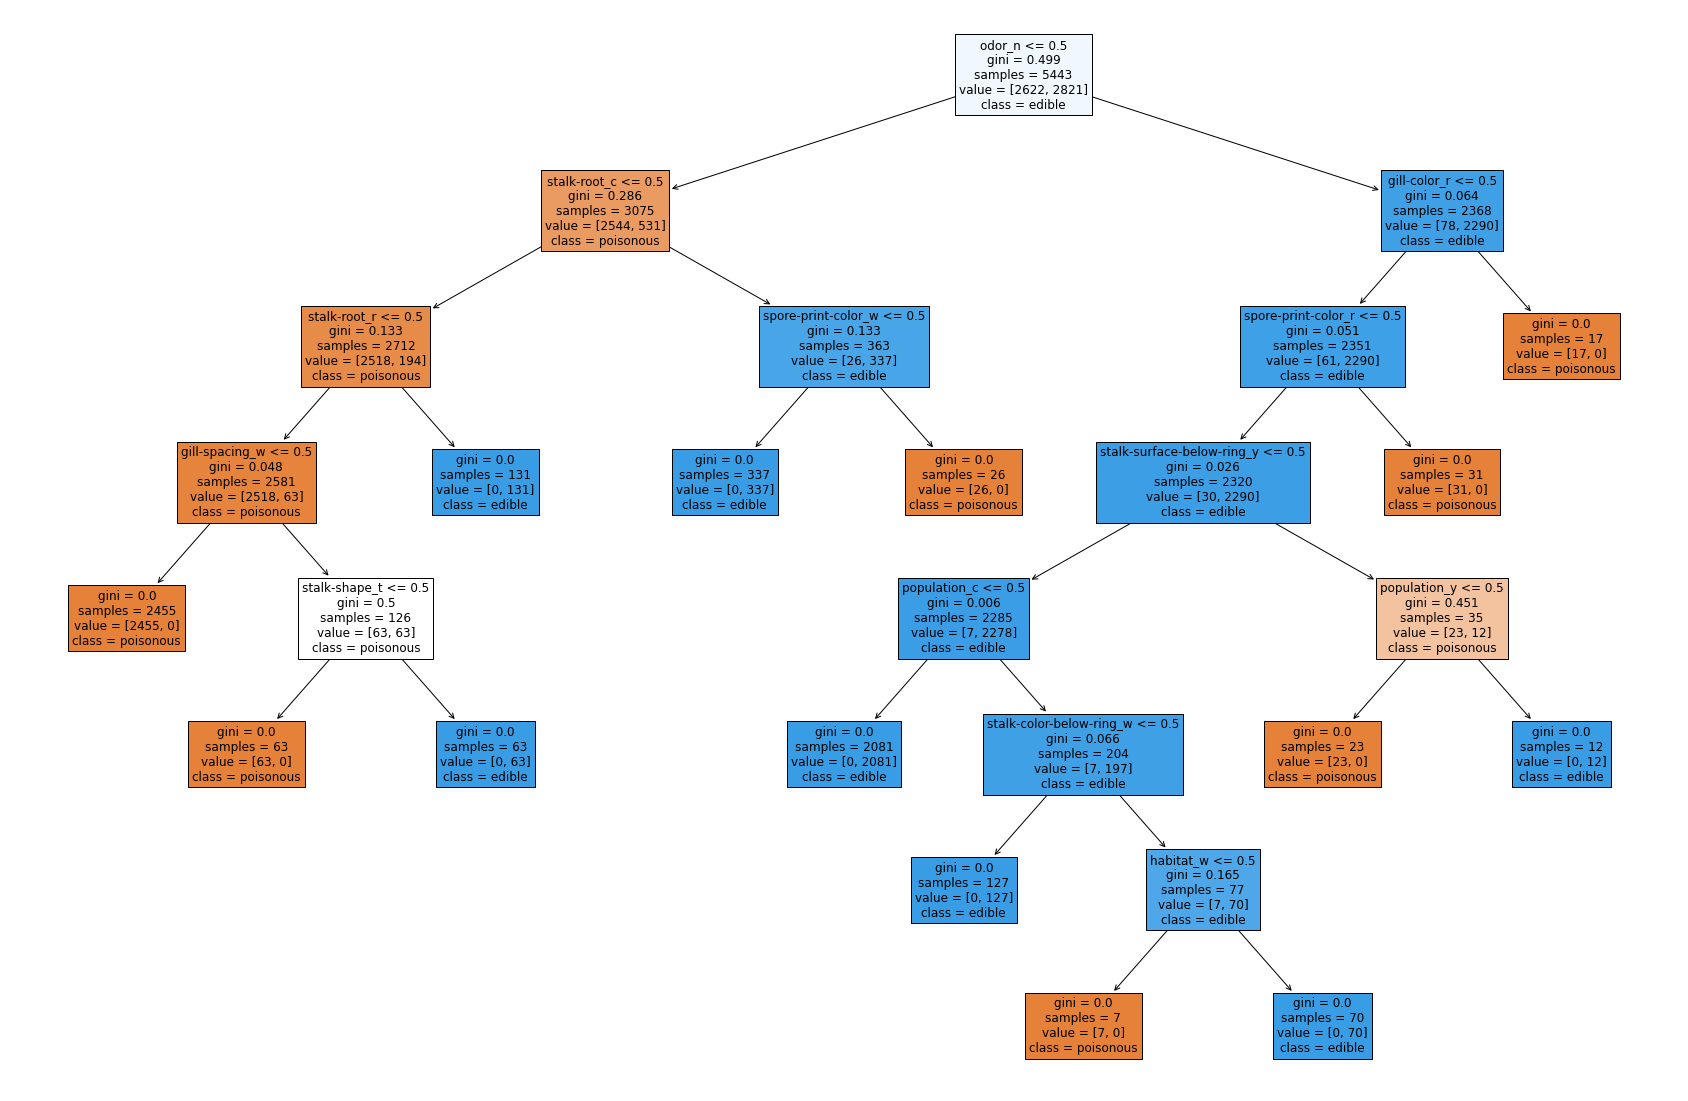

In [10]:
plt.figure(figsize=(30,20))
plot_tree(best_model[-1],
          filled=True,
          feature_names=feature_names,
          class_names=["poisonous", "edible"],
          label="all",
          fontsize=12);
plt.show()

In [11]:
tree_txt = export_text(best_model[-1], feature_names=feature_names)
print(tree_txt)

|--- odor_n <= 0.50
|   |--- stalk-root_c <= 0.50
|   |   |--- stalk-root_r <= 0.50
|   |   |   |--- gill-spacing_w <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- gill-spacing_w >  0.50
|   |   |   |   |--- stalk-shape_t <= 0.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- stalk-shape_t >  0.50
|   |   |   |   |   |--- class: 1
|   |   |--- stalk-root_r >  0.50
|   |   |   |--- class: 1
|   |--- stalk-root_c >  0.50
|   |   |--- spore-print-color_w <= 0.50
|   |   |   |--- class: 1
|   |   |--- spore-print-color_w >  0.50
|   |   |   |--- class: 0
|--- odor_n >  0.50
|   |--- gill-color_r <= 0.50
|   |   |--- spore-print-color_r <= 0.50
|   |   |   |--- stalk-surface-below-ring_y <= 0.50
|   |   |   |   |--- population_c <= 0.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- population_c >  0.50
|   |   |   |   |   |--- stalk-color-below-ring_w <= 0.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- stalk-color-below-ring_w >  0.50
|   |   |   |

In [12]:
tree_nodes = tree_parser.parse_rules(tree_txt)
for branch in tree_nodes:
    conditions_dict, prediction = tree_parser.extract_dictionary_rule(branch)
    branch_txt = tree_parser.gen_text(conditions_dict, prediction)
    print(branch_txt)
    print("#"* 20)

If odor not equal to n, and stalk root not equal to c and r, and gill spacing not equal to w then 0
####################
If odor not equal to n, and stalk root not equal to c and r, and gill spacing equal to w, and stalk shape not equal to t then 0
####################
If odor not equal to n, and stalk root not equal to c and r, and gill spacing equal to w, and stalk shape equal to t then 1
####################
If odor not equal to n, and stalk root equal to r then 1
####################
If odor not equal to n, and stalk root equal to c, and spore print color not equal to w then 1
####################
If odor not equal to n, and stalk root equal to c, and spore print color equal to w then 0
####################
If odor equal to n, and gill color not equal to r, and spore print color not equal to r, and stalk surface below ring not equal to y, and population not equal to c then 1
####################
If odor equal to n, and gill color not equal to r, and spore print color not equal to r

In [13]:
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1294
           1       1.00      1.00      1.00      1387

    accuracy                           1.00      2681
   macro avg       1.00      1.00      1.00      2681
weighted avg       1.00      1.00      1.00      2681

